In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

In [ ]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

In [11]:
a = 0.15
L = a * 6
g = 1.043
h = 1.053
c = 1500

freq_lowerbound = 100
freq_upperbound = 100e3
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
ka = 2*np.pi*freq / c * a

# TS across all angles
phi_all = np.deg2rad(np.arange(-90, 90, 0.5))
fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
TS_all = 20*np.log10(np.abs(fbs_full))

In [12]:
def update_dwba(angle):
    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = a  # width
    height = L  # height
    ellipse_angle = 90-angle  # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, 0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 90, -90))
    ax0.set_yticks(np.arange(-90, 91, 30))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, 1.2), xy=(0.5, 0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(0, 1.2)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

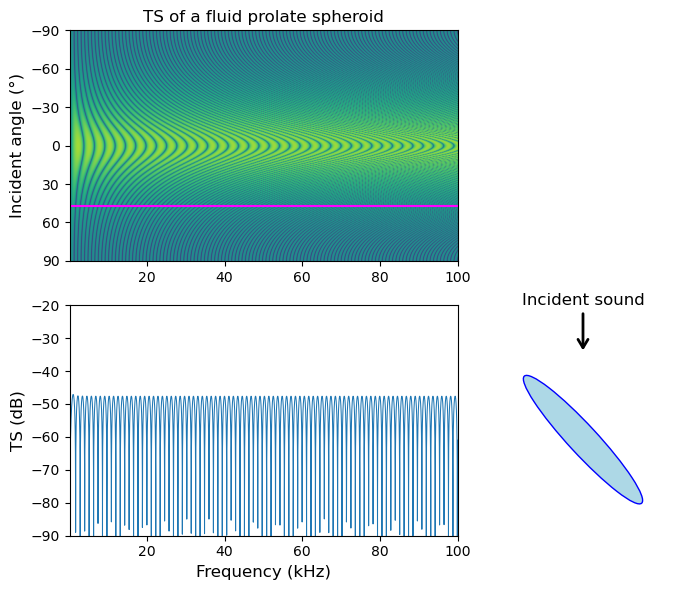

In [13]:
angle = np.random.uniform(-90, 90)
update_dwba(angle)

Text(0, 0.5, 'TS (dB)')

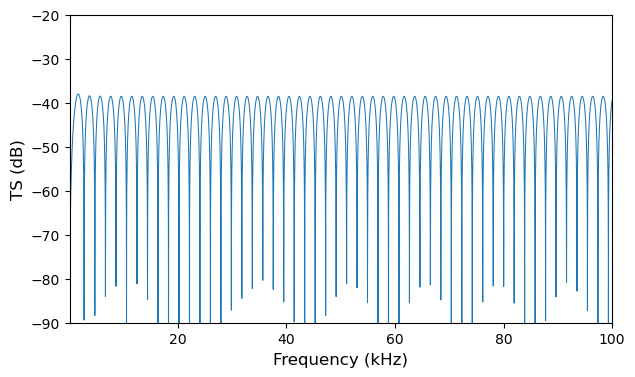

In [15]:
angle = np.random.uniform(-90, 90)

phi = np.deg2rad(angle)
fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
TS = 20*np.log10(np.abs(fbs))

fig, ax1 = plt.subplots(1, 1, figsize=(7,4))
ax1.plot(freq/1e3, TS, lw=0.75)
ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
ax1.set_ylim(-90, -20)
ax1.set_xlabel("Frequency (kHz)", fontsize=12)
ax1.set_ylabel("TS (dB)", fontsize=12)
